In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from numba import njit

from time import time 
from tqdm.notebook import trange

# The Chapman-Kolmogorov equation

Here we will look at the Chapman-Kolmorogov equation, which is an equation that we can use to study some aspects of Markov chains.

## Markov chains

We will now talk a little about discrete random variables. These are not continuous processes in "time", like the Wiener process, but rather chain or series of random numbers with discrete jumps. A discrete _Markov chain_ is a series of random values where the probability distribution of the next value only depends on the current value, not any of the previous values. The property that the next value depends on the current value only is called the _Markov property_. Such a process is sometimes called _memoryless_, since it only "knows" where it is, it does not remember where it came from earlier.


### Example of Markov chain: Sum of dice toss

Toss a die many times, and take the sum of the results. The sum after $N$ tosses is

$$ S_N = \sum_{i=1}^N r_i $$

where $r_i$ is an integer from 1 to 6. The next value will be 

$$ S_{N+1}  = S_N + r_{N+1} $$

so it depends on the current value, but not on any of the previous values. Or said in another way: If we know $S_N$, then we do not gain any additional information about $S_{N+1}$ by also knowing $S_{N-1}$.


### Example of not a Markov chain: Position of a particle with random velocity fluctuations

Say we have some kind of particle (a car, for example) that moves with a velocity that changes randomly. We make a note of the position, $x_i$ of the particle at times $t_i$ with a fixed intervals:  $t_i = i\Delta t$.

To take a concrete example, say that every 1 second we note the GPS position of a car driving in traffic. Say we know the position $\mathbf{x}_N$ after $N$ seconds. In this case, $\mathbf{x}_{N+1}$ depends not only on $\mathbf{x}_N$, but also on $\mathbf{x}_{N-1}$: If $\mathbf{x}_{N} - \mathbf{x}_{N-1}$ is large, then the speed of the car is large, and thus the next step is also likely to be large.


### Another example of a Markov chain: The discrete steps of a numerical SDE solution

With a numerical method like Euler-Maruyama or Milstein or any of the other methods we have looked at, the numerical methods gives us a recipe to go from the current value, $X_i$ to the next value, $X_{i+1}$, where the step depends only on functions of $X_i$ and $t_i$, not on any of the previous values. Hence, the steps in a numerical approximation of an SDE makes up a Markov chain.

## Chapman-Kolmogorov

Say that we have a markov chain, where the probability of stepping from position $x_0$ at time $t_0$ to position $x_1$ at time $t_1$ is given by some transition function:

$$ p(x_1, t_1 | x_0, t_0). $$

As an example: The transition function for a Wiener process is a Gaussian with $\mu=x_0$ and variance $\sigma^2 = t_1 - t_0$:

$$ p(x_1, t_1 | x_0, t_0) = \frac{1}{\sqrt{2 \pi (t_1 - t_0)}} \exp\left( -\frac{1}{2}\frac{(x_1 - x_0)^2}{t_1 - t_0} \right). $$

The Chapman-Kolmogorov equation then tells us that if we start out with some initial distribution, $p_0(x_0, t_0)$, then we will later at time $t_1$ have a distribution $p_1(x_1, t_1)$, which is given by

$$ p_1(x_1, t_1) = \int_{-\infty}^{\infty} p(x_1, t_1 | x_0, t_0) \, p_0(x_0, t_0) \, \mathrm{d} x_0. $$

The idea is that we take the product of the initial distribution and the transition probability density, and integrate over all initial conditions. See for example Kloeden & Platen, p. 35 or Gihman & Skorokhod (1972, p. 100). Note that different authors sometimes use a bit different notation, the one shown here is from Gihman & Skorokhod.

## Applying Chapman-Kolmogorov to the steps of the Euler-Maruyama scheme

Say that we want to solve the SDE

$$ \mathrm{d} X = a(X, t) \, \mathrm{d}t + b(X, t) \, \mathrm{d}W, $$

with the Euler-Maruyama scheme:

$$ X_{n+1} = X_n + a(X_n, t_n) \, \Delta t + b(X_n, t_n) \, \Delta W_n. $$

Then the transition function from $X_n$ to $X_{n+1}$ is a Gaussian with $\mu = X_n  + a(X_n, t_n) \, \Delta t$, and $\sigma^2 = \big(b(X_n, t_n)\big)^2 \Delta t$:

$$ p(X_{n+1}, t_{n+1} | X_n, t_n) = \frac{1}{\sqrt{2 \pi (t_{n+1} - t_n)} b(X_n, t_n)} \, \exp\left( -\frac{1}{2}\frac{\Big[X_{n+1} - \big(X_n  + a(X_n, t_n)(t_{n+1}-t_n)\big)\Big]^2}{\big(b(X_n, t_n)\big)^2 \,(t_{n+1} - t_n)} \right). $$

This is illustrated below, by comparing the distribution after a single step with Euler-Maruyama to the (numerically) integrated Chapman-Kolmogorov equation.

In [2]:
# An SDE solver
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dt
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW


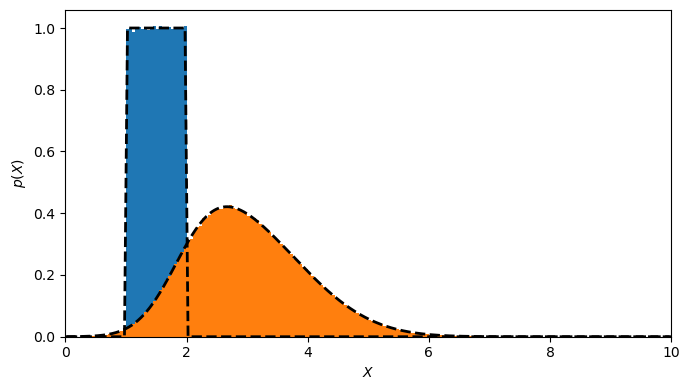

In [27]:
# Implementing a and b as functions, even though they are constant here,
# for consistency with the general solver
def a(X, t):
    alpha = 1
    return alpha * X

def b(X, t):
    beta = 0.5
    return beta * X + 0.001


# Initial distribution
Np = 1000000
X0 = np.random.uniform(low=1, high=2, size=Np)
# timestep
dt = 1

t0 = 0
t1 = t0 + dt


# Take a single step with Euler-Maruyama
X1 = EM(X0, t0, dt, a, b)


bins = np.linspace(0, 10, 201) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the initial and final particle distributions
fig = plt.figure(figsize = (7, 4))
plt.hist(X0, bins=bins, density=True)
plt.hist(X1, bins=bins, density=True)

# Work out and plot the initial (analytical) density
def uniform(x, low=1, high=2):
    return np.where((low <= x) & (x <= high), 1.0/(high-low), 0.0)

plt.plot(mids, uniform(mids), '--', c='k', lw=2)

# Transition density
def p(x1, t1, x0, t0):
    return np.exp(-0.5*((x1 - (x0 + a(x0, t0)*(t1-t0)))**2 / (b(x0, t0)**2 * (t1-t0)))) / np.sqrt(2*np.pi*b(x0, t0)**2 * (t1-t0))

# Numerical integral of Chapman-Kolmogorov
x, dx = np.linspace(0, 10, 10000, retstep=True)
p1 = np.sum(dx * p(x[:,None],t1,x[None,:], t0) * uniform(x[None,:]), axis=1)

plt.plot(x, p1, '--', c='k', lw=2)


plt.xlabel('$X$')
plt.ylabel('$p(X)$')
plt.xlim(0, 10)
#plt.legend()
plt.tight_layout()

# References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5